<h1> Model understanding </h1>

The project was created to consolidate knowledge gained from the chapter 4 of a book Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems by Aurélien Géron and partially uses publicly available code.

In [236]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, SGDRegressor
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from pprint import pprint
import time
from sklearn.preprocessing import PolynomialFeatures
from sklearn import datasets
import copy
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure

%run my_models.ipynb

<h1> Linear Regression </h1>

In [61]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_train.shape, df_test.shape

((700, 2), (300, 2))

In [91]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 0 to 699
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       699 non-null    float64
 1   y       699 non-null    float64
dtypes: float64(2)
memory usage: 16.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       300 non-null    int64  
 1   y       300 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.8 KB


(None, None)

Only 1 row for 700 instances has nan, so we can easily drop it.

In [92]:
df_train = df_train.dropna()

In [93]:
X = df_train['x'].to_numpy()
y = df_train['y'].to_numpy().ravel()
X_test = df_test['x'].to_numpy()
y_test = df_test['y'].to_numpy().ravel()

print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)

(699,)
(699,)
(300,)
(300,)


<h2> Importance of standarization - example </h2>

As we know, Linear Regression in Batch Gradient Descent version requires standarized data. Let's compare this model in situation when data is standarized and when it's not.

<h4> With standarization </h4>

In [94]:
X_std = X.copy()
X_test_std = X_test.copy()

std_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ])

X_std = std_pipeline.fit_transform(X_std.reshape(-1, 1))
X_test_std = std_pipeline.transform(X_test_std.reshape(-1, 1))

print(X_std.shape)
print(X_test_std.shape)

(699, 1)
(300, 1)


In [105]:
for i in range(6):
    lr_BGD = linear_regression_BGD()
    lr_BGD.fit(X_std, y, 20, eta=0.1)
y_pred = lr_BGD.predict(X_test_std)
mse = mean_squared_error(y_test, y_pred)
print('mse ', mse)


mse  10.54152116978474


<h4> Without standarization </h4>

In [106]:
for i in range(6):
    lr_BGD = linear_regression_BGD()
    lr_BGD.fit(X, y, 20, eta=0.1)
    print(lr_BGD.theta)

[-4.52760765e+54 -3.02208067e+56]
[-4.52760765e+54 -3.02208067e+56]
[-4.52760765e+54 -3.02208067e+56]
[-4.52760765e+54 -3.02208067e+56]
[-4.52760765e+54 -3.02208067e+56]
[-4.52760765e+54 -3.02208067e+56]


As we can see, this time theta's value is not finite. Let's try to reduce learning_rate (eta).

In [108]:
for i in range(6):
    lr_BGD = linear_regression_BGD()
    lr_BGD.fit(X, y, 20, eta=0.0001)
y_pred = lr_BGD.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('mse ', mse)

mse  9.457200154628323


Conclusion 1: Not standarizing data can lead to situation, where our learning parameter is too large. So we have to reduce it, however training time increases.

<h2> Learning Curves interpretation - example </h2>

Let's train Linear Regression in Stochastic Gradient Descent version and try to interpret learning curves.

mse  3464.291087139079


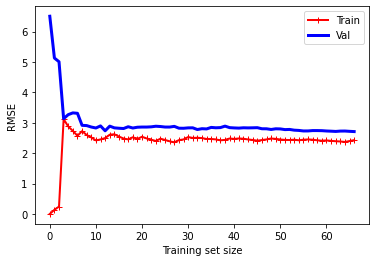

In [120]:
lr_SVD = linear_regression_SVD()
lr_SVD.fit(X_std, y, 20)
y_pred = lr_SVD.predict(X_test_std)
mse = mean_squared_error(y_test, y_pred)
print('mse ', mse)

plot_learning_curves(lr_SVD, X_std, y, end_iteration=int(0.1*len(X_std)), start_iteration=2, random_state=5)

The model clearly underfits data. Training curve is low in the beginning, then gradually increases to a plateau. On the other hand validation curve is high in the beginning beginning and decreases to the plateu.

<h2> Theta paths of different implementations of Linear Regression </h2>

Let's train 3 Linear Regression models using BGD, SGD and MbGD, then compare its theta paths.

In [159]:
lr_BGD = linear_regression_BGD()
lr_BGD.fit(X_std, y, 200)
y_pred = lr_BGD.predict(X_test_std)
theta_path_BGD = lr_BGD.theta_path

lr_SGD = linear_regression_SGD()
lr_SGD.fit(X_std, y, 20, random_state=42)
y_pred = lr_SGD.predict(X_test_std)
theta_path_SGD = lr_SGD.theta_path

lr_MbGD = linear_regression_MbGD()
lr_MbGD.fit(X_std, y, 20, batch_size_ratio=0.05, random_state=42)
y_pred = lr_MbGD.predict(X_test_std)
theta_path_MbGD = lr_MbGD.theta_path


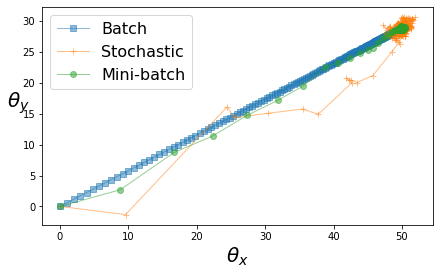

In [160]:
linear_regression_compare_paths([theta_path_BGD, theta_path_SGD, theta_path_MbGD], ['Batch', 'Stochastic', 'Mini-batch'])

As we can see, implementations behave in a very intuition way. Batch based on full gradient of a cost function chooses the shortest path. Stochastic, based on gradients of single instances, bounces up and down, its theta path is complicated but training time is the shortest. Mini-batch centers these two solutions.

<h1> Polynomial Regression </h1>

<h2> Polynomial Regression - example </h2>

In [163]:
random.seed(2)

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0

degrees = random.sample(range(0, 6), 3)
constants = random.sample(range(-m, m), 3)

scaler = StandardScaler()
X = scaler.fit_transform(X)

for i in range(3):
    y = y + constants[i] * X**degrees[i]
               
y = y + np.random.randn(m, 1)

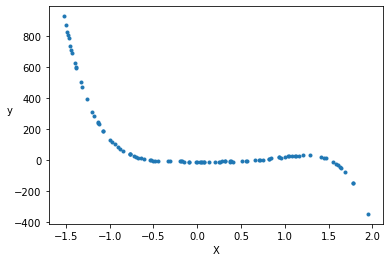

In [164]:
plt.plot(X, y, '.')
plt.xlabel('X')
plt.ylabel('y', rotation=0)
plt.show()

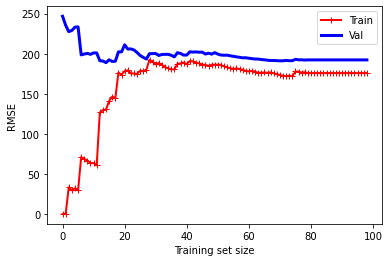

In [168]:
polynomial_regression = Pipeline([
 ("poly_features", PolynomialFeatures(degree=1, include_bias=False)),
 ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y, end_iteration = int(len(X)), random_state=1)

This model underfits data. Training curve starts at low level and increases to a plateau. Validation curve starts at high level and decreases to the plateau.

Let's try to increase degrees of freedom count.

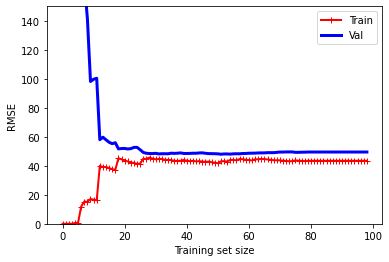

In [169]:
polynomial_regression = Pipeline([
 ("poly_features", PolynomialFeatures(degree=3, include_bias=False)),
 ("lin_reg", LinearRegression()),
])

plt.ylim([0, 150])
plot_learning_curves(polynomial_regression, X, y, end_iteration = int(len(X)), random_state=1)

Again, underfitting, but smaller...

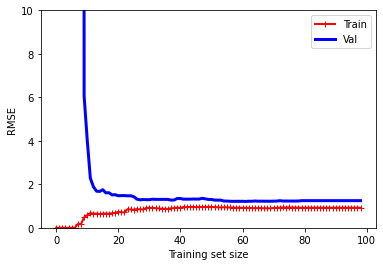

In [181]:
polynomial_regression = Pipeline([
 ("poly_features", PolynomialFeatures(degree=6, include_bias=False)),
 ("lin_reg", LinearRegression()),
])

plt.ylim([0, 10])
plot_learning_curves(polynomial_regression, X, y, end_iteration = int(len(X)), random_state=1)

This model has a pretty good fit. Training curve flattens and validation curve is high in the beginning and flattens gradually. What is important, from a certain point, there is no gap between the curves.

Let's reveal degrees and constants.

In [179]:
print('degrees: ', degrees)
print('constants: ', constants)

degrees:  [0, 5, 4]
constants:  [-8, -57, 88]


<h2> Linear Regression, Lasso feature selection - example </h2>

Let's compare paths of Linear Regression with regularizations (None vs Ridge vs Lasso vs Elastic Net) in Batch Gradient Descent version with a pretty big value of alpha -> 4.

At first, let's create some data, where X has 2 dimensions and only first dimension describes y.

In [184]:
random.seed(42)

m = 1000
X = np.array([(np.random.rand(m, 1) - 3)[:,0], (0.000001 * np.random.rand(m, 1))[:,0]])
y = np.array([20* X[0,:]])[0,:]

X_train = X[:,:800].copy()
y_train = y[:800].copy()
X_test = X[:,800:].copy()
y_test = y[800:].copy()


X_train = X_train.T
X_test = X_test.T


X_std = std_pipeline.fit_transform(X_train)
X_test_std = std_pipeline.transform(X_test)

In [185]:
plainlr_BGD = linear_regression_BGD()
plainlr_BGD.fit(X_std,y_train, 4000, regularization=None, theta=np.array([10,20,30]))
y_pred = plainlr_BGD.predict(X_test_std)
plainlr_path = plainlr_BGD.theta_path
mean_squared_error(y_test, y_pred)

3.053787849193647e-26

In [186]:
ridge_BGD = linear_regression_BGD()
ridge_BGD.fit(X_std,y_train, 4000, regularization='ridge', theta=np.array([10,20,30]), alpha=4)
y_pred = ridge_BGD.predict(X_test_std)
ridge_path = ridge_BGD.theta_path
mean_squared_error(y_test, y_pred)

15.119538710448605

In [187]:
lasso_BGD = linear_regression_BGD()
lasso_BGD.fit(X_std,y_train, 4000, regularization='lasso', theta=np.array([10,20,30]), alpha=4)
y_pred = lasso_BGD.predict(X_test_std)
lasso_path = lasso_BGD.theta_path
mean_squared_error(y_test, y_pred)

4.008823817927311

In [188]:
elastic_BGD = linear_regression_BGD()
elastic_BGD.fit(X_std,y_train, 4000, regularization='elastic', theta=np.array([10,20,30]), mix_ratio=0.5, alpha=4)
y_pred = elastic_BGD.predict(X_test_std)
elastic_path = elastic_BGD.theta_path
mean_squared_error(y_test, y_pred)

11.67478068949671

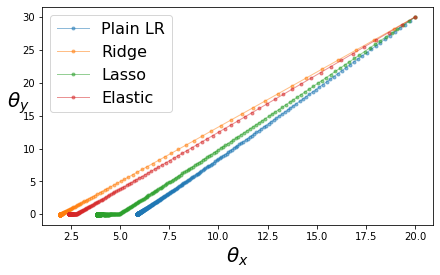

In [189]:
linear_regression_compare_paths([plainlr_path[:,1:], ridge_path[:,1:], lasso_path[:,1:], elastic_path[:,1:]], ['Plain LR', 'Ridge', 'Lasso', 'Elastic'], markers='.')

We can see in the example that the Lasso tends to get rid of unnecessary features (by quickly decreasing its weights to 0 -> we can see that, Lasso is focused more on decreasing useless feature's weight (theta_y), because it doesn't take into account how big is given theta's vector cell, so if it's in real small, it decreases to 0 quickly.

<h2> Early stopping - example </h2>

As we know, when validation error stops decreasing, it may starts go back up, what means that model has started to overfit the training data. Let's test our early stopping implementation, which keeps model that its validation error is minimal.

At first, get some data and standarize it.

In [190]:
X = df_train['x'].to_numpy()
y = df_train['y'].to_numpy()
X_val = df_test['x'].to_numpy()
y_val = df_test['y'].to_numpy()

In [191]:
X_std = X.copy()
X_val_std = X_val.copy()

std_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ])

X_std = std_pipeline.fit_transform(X_std.reshape(-1, 1))
X_val_std = std_pipeline.transform(X_val_std.reshape(-1, 1))

print(X_std.shape)
print(X_val_std.shape)
print(y.shape)
print(y_val.shape)

(699, 1)
(300, 1)
(699,)
(300,)


Now, train a model with early stopping.

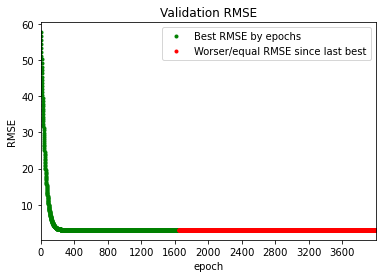

best_epoch:  1648
best_theta:  [49.93986917 28.95283303]


In [192]:
plainlr_BGD = linear_regression_BGD()

best_model = early_stopping(X_std, y, X_val_std, y_val, plainlr_BGD, 4000)

As we can see, the best model was reached in epoch 1648.

<h2> Logistic Regression - decision boundaries </h2>

Let's make a simple classifiaction datasets for 1,2 and 3 features using sklearn and plot decision boundaries for them.

<h3> One feature dataset </h3>

In [193]:
%%capture --no-display

X, y = datasets.make_classification(n_samples=1000, n_features=1, n_informative=1, n_redundant=0, n_clusters_per_class=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_std = X_train.copy()
X_val_std = X_test.copy()

std_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ])

X_std = std_pipeline.fit_transform(X_std.reshape(-1, 1))
X_val_std = std_pipeline.transform(X_val_std.reshape(-1, 1))

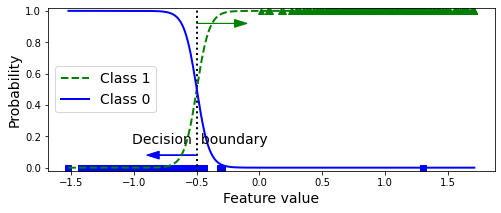

In [194]:
%%capture --no-display

lr = logistic_regression_BGD()
lr.fit(X_std,y_train, 40, theta=np.array([10, 20]))
decision_boundary(X_std, y_train, fitted_model=lr)

<h3> Two features dataset </h3>

In [195]:
%%capture --no-display

X, y = datasets.make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_std = X_train.copy()
X_val_std = X_test.copy()

std_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ])

X_std = std_pipeline.fit_transform(X_std)
X_val_std = std_pipeline.transform(X_val_std)

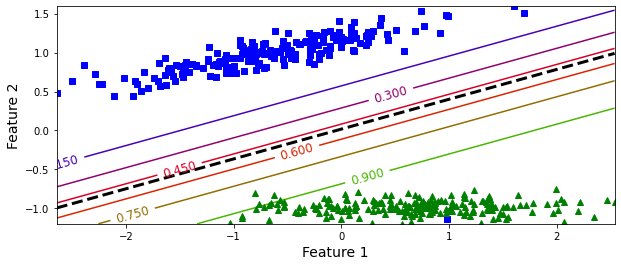

In [196]:
%%capture --no-display

lr = logistic_regression_BGD()
lr.fit(X_std,y_train, 4000, theta=np.array([0,0,0]))
decision_boundary(X_std, y_train, fitted_model=lr)

<h3> Three features </h3>

In [197]:
%%capture --no-display

X, y = datasets.make_classification(n_samples=1000, n_features=3, n_informative=2, n_redundant=1, n_clusters_per_class=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_std = X_train.copy()
X_val_std = X_test.copy()

std_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ])

X_std = std_pipeline.fit_transform(X_std)
X_val_std = std_pipeline.transform(X_val_std)

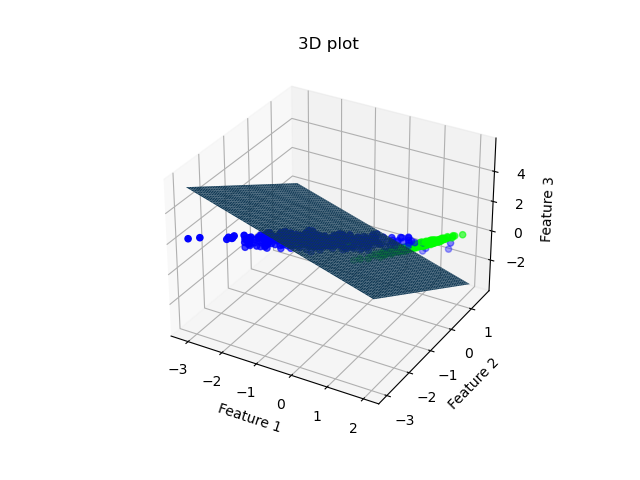

In [198]:
%%capture --no-display

%matplotlib widget
# Interactions with plot may not work with jupyter lab. Please use jupyter notebook instead.

lr = logistic_regression_BGD()
lr.fit(X_std,y_train, 4000, theta=np.array([10, 20, 30, 40]))
decision_boundary(X_std, y_train, fitted_model=lr)

<h2> Softmax</h2>

<h3> Multiclass decision boundary - example </h3>

In [207]:
X, y = datasets.make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, n_classes=3)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_std = X_train.copy()
X_val_std = X_test.copy()

std_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ])

X_std = std_pipeline.fit_transform(X_std)
X_val_std = std_pipeline.transform(X_val_std)

In [208]:
softmax_reg = softmax_regression_BGD()
softmax_reg.fit(X_std, y_train, n_iterations=500, n_classes=3, theta=np.array([[0,0,0],[0,0,0],[0,0,0]]))

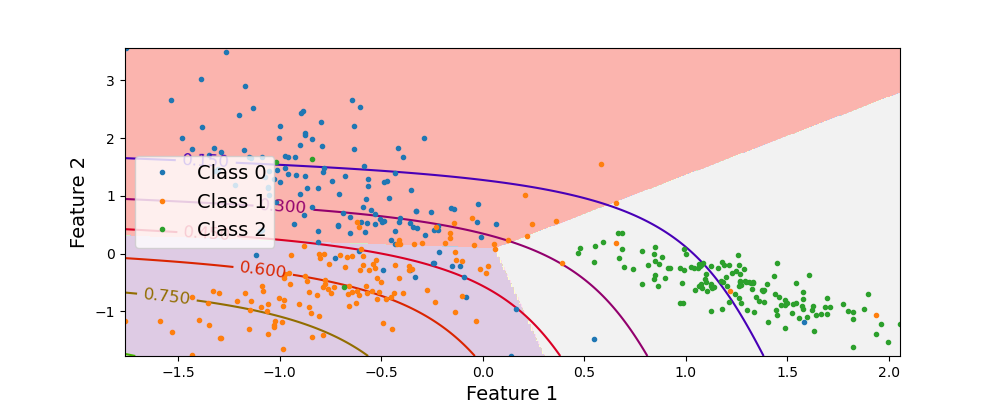

In [209]:
%%capture --no-display
decision_boundary_multiclass(X_std,y_train, 3)

<h2> Decision Trees </h2>

In [222]:
%%capture --no-display

X, y = make_classification(n_samples=100, n_features=5, n_informative=2, n_redundant=3, n_clusters_per_class=1, n_classes=3, random_state = 42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

y_train = np.expand_dims(y_train, axis=1)

max_depth = 5

dt = decision_tree_classification()

features_order, thresholds_order, predicted_labels, node_type = dt.fit(X_train, y_train, max_depth)

y_pred = dt.predict(X_test)

accuracy_score(y_test, y_pred, normalize=True)

dt.plot()

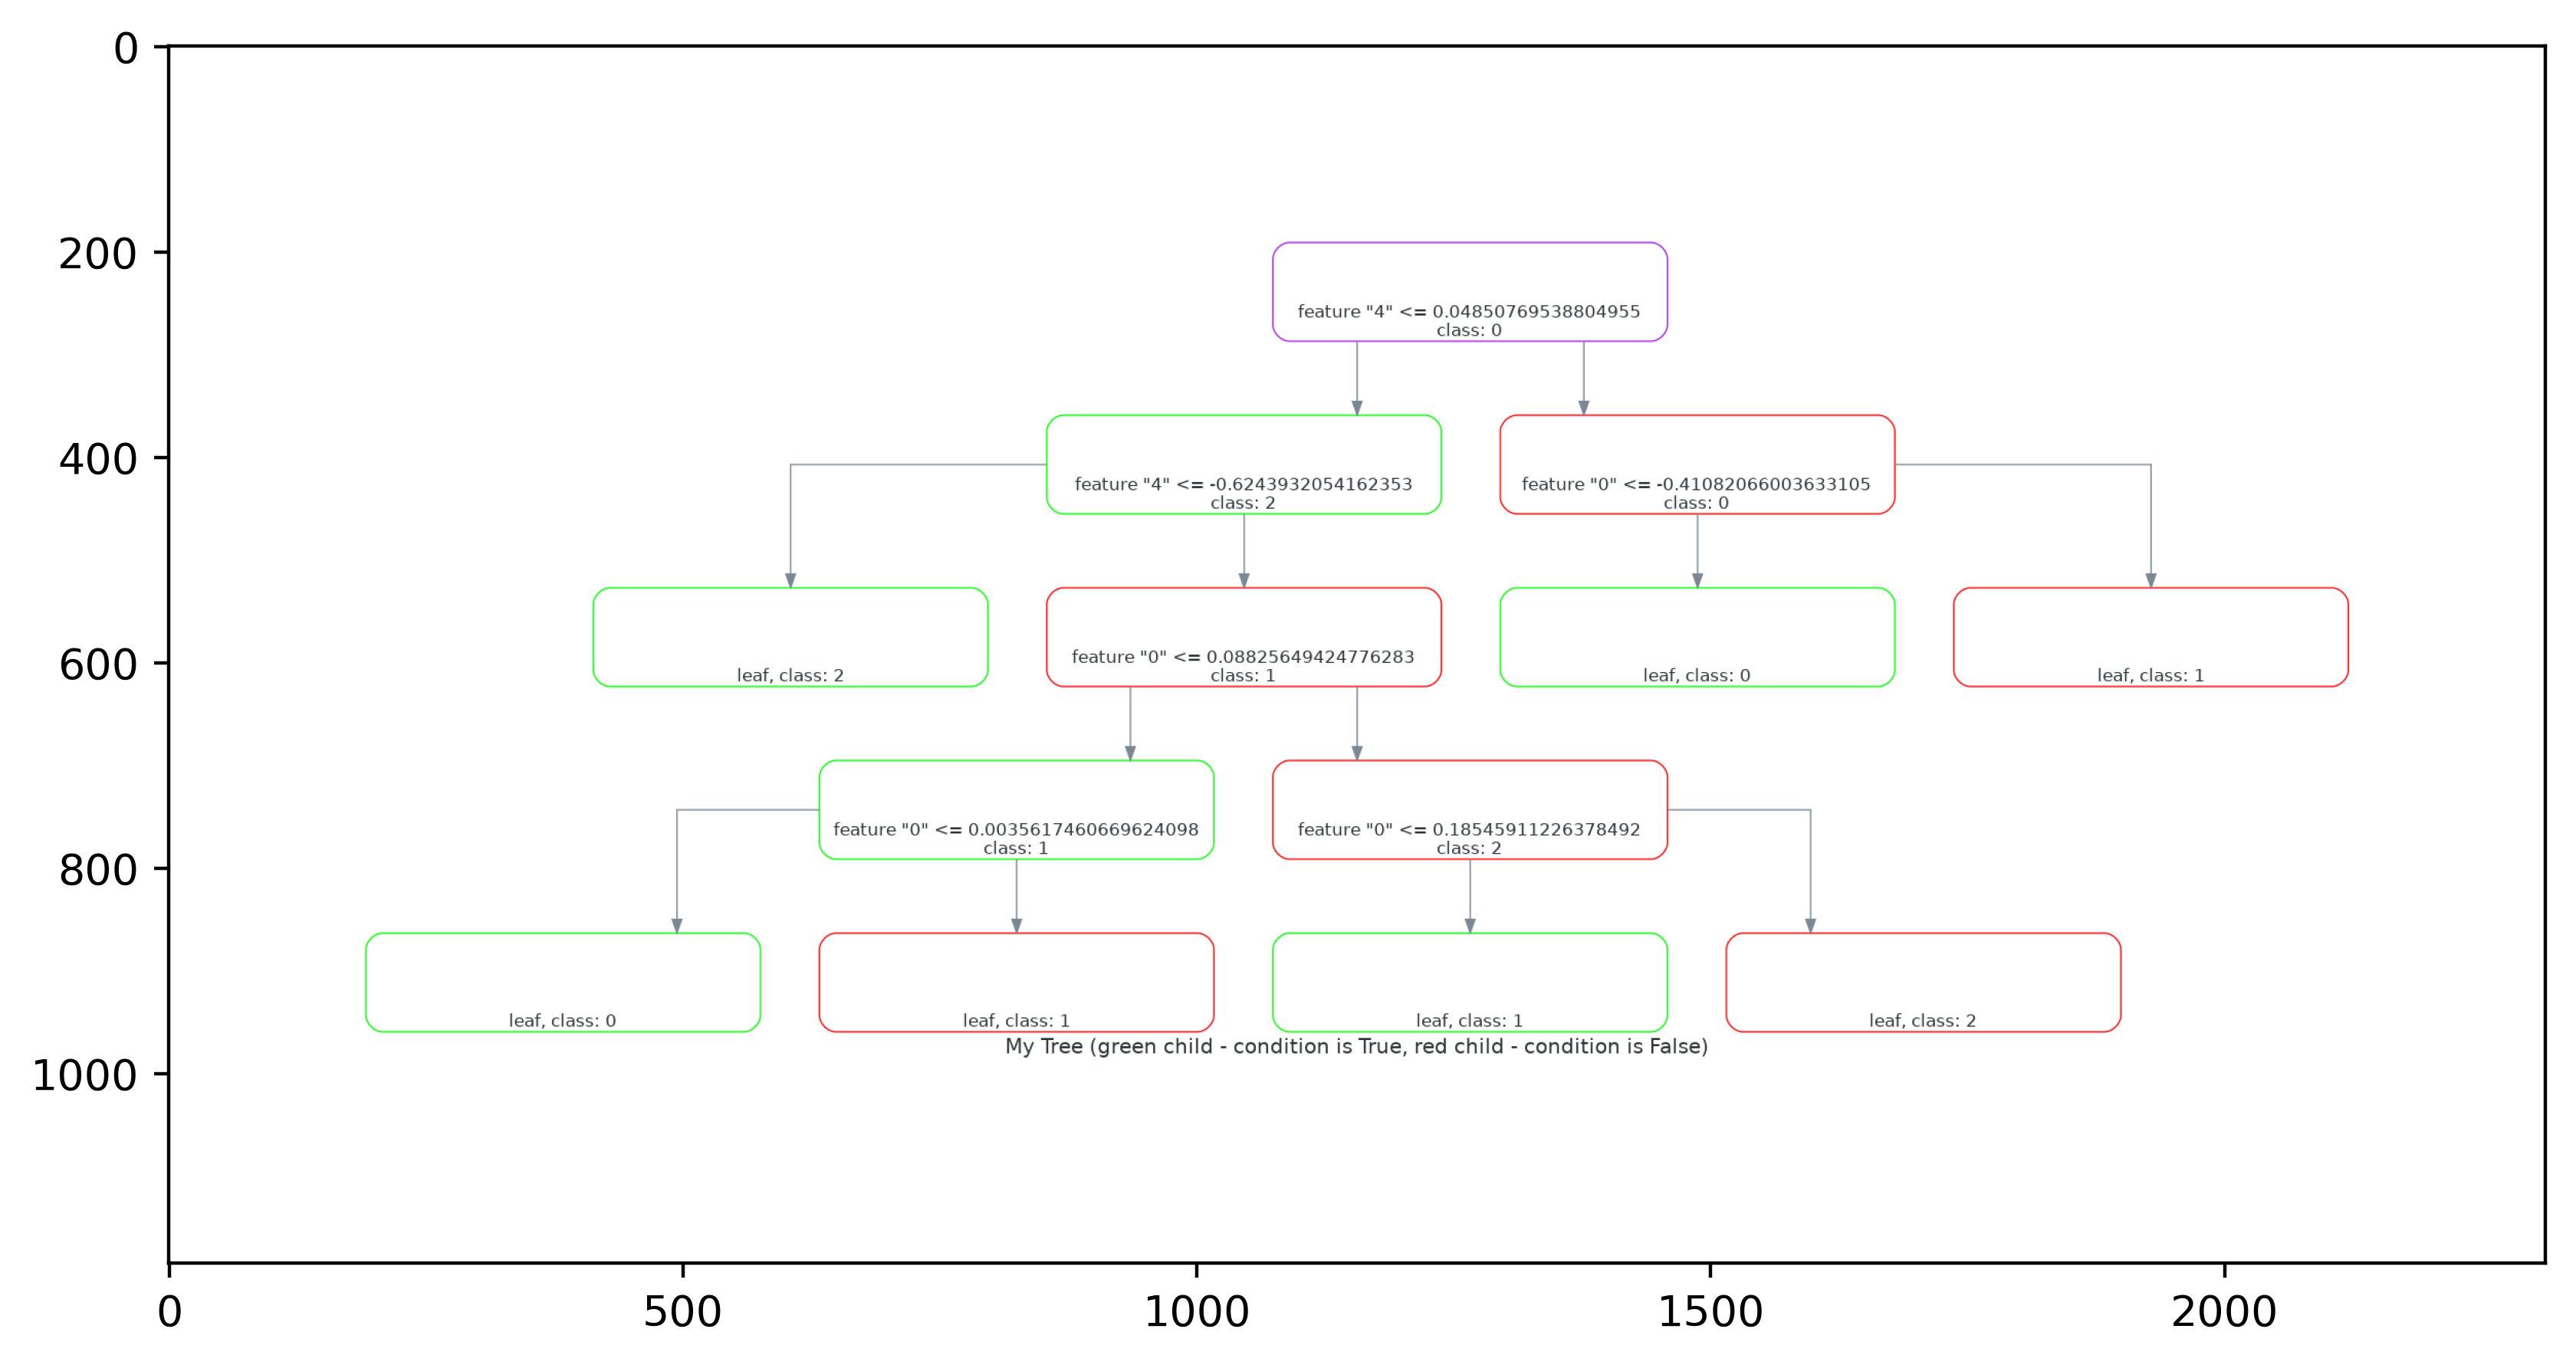

In [239]:
figure(figsize=(10, 10), dpi=400)

img = mpimg.imread('my_tree_(green_child_-_condition_is_true,_red_child_-_condition_is_false).png')
imgplot = plt.imshow(img)
plt.show()